In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
import openllm

In [2]:
model_name = "./models/phi-1_5"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

In [3]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [4]:
print(model)

PhiForCausalLM(
  (model): PhiModel(
    (embed_tokens): Embedding(51200, 2048)
    (embed_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-23): 24 x PhiDecoderLayer(
        (self_attn): PhiAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=True)
          (k_proj): Linear(in_features=2048, out_features=2048, bias=True)
          (v_proj): Linear(in_features=2048, out_features=2048, bias=True)
          (dense): Linear(in_features=2048, out_features=2048, bias=True)
          (rotary_emb): PhiRotaryEmbedding()
        )
        (mlp): PhiMLP(
          (activation_fn): NewGELUActivation()
          (fc1): Linear(in_features=2048, out_features=8192, bias=True)
          (fc2): Linear(in_features=8192, out_features=2048, bias=True)
        )
        (input_layernorm): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
        (resid_dropout): Dropout(p=0.0, inplace=False)
      )
    )
    (final_layernorm): LayerNorm((2048,), e

In [5]:
prompt = "i am a robot, I need to"
inputs = tokenizer(prompt, return_tensors="pt")
inputs

{'input_ids': tensor([[  72,  716,  257, 9379,   11,  314,  761,  284]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1]])}

In [25]:
with torch.no_grad():
    outputs = model(**inputs)

logits = outputs.logits
print(logits.shape)

AttributeError: 'Tensor' object has no attribute 'logits'

In [7]:
last_logits = logits[0, -1, :]
next_token_id = last_logits.argmax()
next_token_id

tensor(307)

In [49]:
tokenizer.decode(next_token_id)

' be'

In [8]:
top_k = torch.topk(last_logits, k=10)
tokens = [tokenizer.decode(tk) for tk in top_k.indices]
tokens

[' be',
 ' move',
 ' learn',
 ' take',
 ' calculate',
 ' make',
 ' know',
 ' do',
 ' understand',
 ' perform']

In [9]:
def generate_token(inputs):
    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    last_logits = logits[0, -1, :]
    next_token_id = last_logits.argmax()
    return next_token_id

In [10]:
generated_tokens = []
next_inputs = inputs
durations_s = []
for _ in range(10):
    t0 = time.time()
    next_token_id = generate_token(next_inputs)
    durations_s += [time.time() - t0]
    
    next_inputs = {
        "input_ids": torch.cat(
            [next_inputs["input_ids"], next_token_id.reshape((1, 1))],
            dim=1),
        "attention_mask": torch.cat(
            [next_inputs["attention_mask"], torch.tensor([[1]])],
            dim=1),
    }
    
    next_token = tokenizer.decode(next_token_id)
    generated_tokens.append(next_token)

print(f"{sum(durations_s)} s")
print(generated_tokens)

3.2815980911254883 s
[' be', ' able', ' to', ' understand', ' and', ' respond', ' to', ' human', ' language', '.']


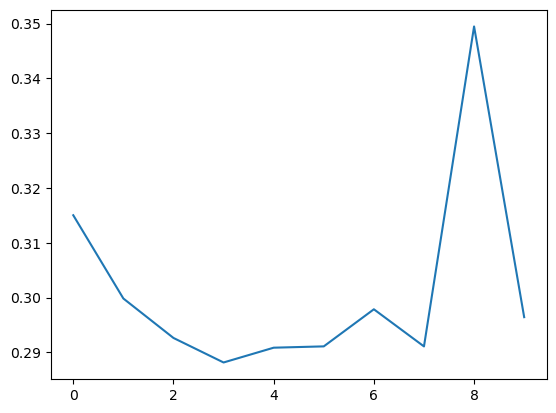

In [51]:
plt.plot(durations_s)
plt.show()

In [12]:
def generate_token_with_past(inputs):
    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    last_logits = logits[0, -1, :]
    next_token_id = last_logits.argmax()
    return next_token_id, outputs.past_key_values

In [13]:
generated_tokens = []
next_inputs = inputs
durations_cached_s = []
for _ in range(10):
    t0 = time.time()
    next_token_id, past_key_values = \
        generate_token_with_past(next_inputs)
    durations_cached_s += [time.time() - t0]
    
    next_inputs = {
        "input_ids": next_token_id.reshape((1, 1)),
        "attention_mask": torch.cat(
            [next_inputs["attention_mask"], torch.tensor([[1]])],
            dim=1),
        "past_key_values": past_key_values,
    }
    
    next_token = tokenizer.decode(next_token_id)
    generated_tokens.append(next_token)

print(f"{sum(durations_cached_s)} s")
print(generated_tokens)

2.360388994216919 s
[' be', ' able', ' to', ' understand', ' and', ' respond', ' to', ' human', ' language', '.']


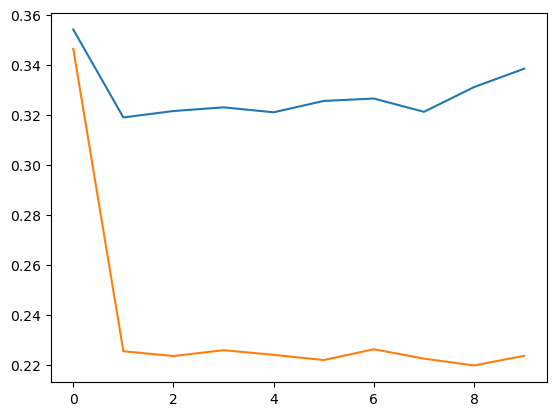

In [14]:
plt.plot(durations_s)
plt.plot(durations_cached_s)
plt.show()